In [3]:
import sys
sys.path.append(r"./custom_models/dl_models/ffn")

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.model_selection import train_test_split

In [5]:
from custom_models.dl_models.ffn import ffn
from custom_models.dl_models.ffn.utils.optimization import *

In [6]:
iris_dataset = datasets.load_iris()
iris_dataset.target_names
X = iris_dataset.data
y = iris_dataset.target

In [7]:
def one_hot_encoding(y):
    output_shape = (y.shape[0], np.unique(y).shape[0])
    expected_output = np.zeros(output_shape)
    np.put_along_axis(expected_output, np.expand_dims(y.astype(int), axis=1), 1, axis=1)
    return expected_output

In [8]:
y = one_hot_encoding(y)
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, random_state=42)


In [9]:
n_features = X.shape[1]
n_classes = y.shape[1]

In [10]:
np.random.seed(42)
model = ffn.Custom_FFN(architecture=[n_features, 10, 5, n_classes])

### Checking optimization correctness

In [11]:
def compute_grad_numerically(model, X, y, layer_n=0, eps=10e-2, reg_lambda=0, reg_type=2):
    """
    Численная производная целевой функции.
    neuron - объект класса Neuron с вертикальным вектором весов w,
    X - вертикальная матрица входов формы (n, m), на которой считается сумма квадратов отклонений,
    y - правильные ответы для тестовой выборки X,
    J - целевая функция, градиент которой мы хотим получить,
    eps - размер $\delta w$ (малого изменения весов).
    """
    w_0 = model.parameters['weights'][layer_n]
    num_grad = np.zeros(w_0.shape)
    loss_function = model.loss_function

    
    for i in range(w_0.shape[0]):
        for j in range(w_0.shape[1]):
            
            old_wi = model.parameters['weights'][layer_n][i, j].copy()
            # Меняем вес
            model.parameters['weights'][layer_n][i, j] += eps
            
            # Считаем новое значение целевой функции и вычисляем приближенное значение градиента
            preds = model.forward(X)
            loss = loss_function(preds, y) + reg_lambda * regularization(model, reg_l=reg_type)
            num_grad[i, j] = (loss)/(2*eps)

            model.parameters['weights'][layer_n][i, j] -= 2*eps
            
            preds = model.forward(X)
            loss = loss_function(preds, y) + reg_lambda * regularization(model, reg_l=reg_type)
            num_grad[i, j] -= (loss)/(2*eps)

            # Возвращаем вес обратно. Лучше так, чем -= eps, чтобы не накапливать ошибки округления
            model.parameters['weights'][layer_n][i, j] = old_wi
            
    # проверим, что не испортили нейрону веса своими манипуляциями
    assert np.allclose(model.parameters['weights'][layer_n], w_0), "МЫ ИСПОРТИЛИ НЕЙРОНУ ВЕСА"
    return num_grad

In [12]:
preds = model.forward(X)
grads = calculate_gradient(model, X, y, preds, reg_lambda=0.1, reg_type=2)

In [13]:
num_grad = compute_grad_numerically(model, X, y, layer_n=2, eps=0.00001, reg_lambda=0.1, reg_type=2)

In [14]:
num_grad

array([[-0.18769636,  0.32441762,  0.146324  ],
       [-0.19125932,  0.25720646,  0.05315877],
       [-0.20467309,  0.42762153,  0.15685943],
       [-0.10876894,  0.414575  ,  0.15590123],
       [-0.19986526,  0.42046514,  0.10309438]])

In [15]:
grads['weights'][2]

array([[-0.18769636,  0.32441762,  0.146324  ],
       [-0.19125932,  0.25720646,  0.05315877],
       [-0.20467309,  0.42762153,  0.15685943],
       [-0.10876894,  0.414575  ,  0.15590123],
       [-0.19986526,  0.42046514,  0.10309438]])

In [16]:
np.linalg.norm(grads['weights'][2] - num_grad)

1.552542117133668e-10

### Train and test on gathered toy data

In [17]:
loss_log = SGD(model, X_train, y_train, batch_size=50, 
            lr=0.1, eps=0.1e-4, max_epochs=400, max_convergences=20, lr_decay=1)

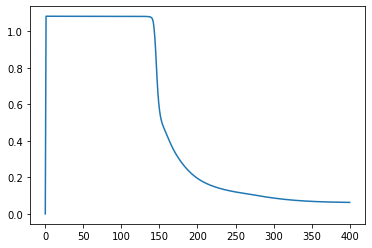

In [18]:
plt.plot(loss_log)

In [19]:
test_preds = model.forward(X_test)

In [22]:
(test_preds.argmax(axis=1) == y_test.argmax(axis=1)).mean()

0.9777777777777777

In [21]:
y_test.shape

(45, 3)